In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [5]:
data_path = "/papers_2000/"

## Citation Table

In [44]:
def read_table(kws_source="kws", method="bkmeans"):
    df = pd.read_csv("../data/processed/papers_2000/"+kws_source+"/"+method+"_mean_table.csv")
    df = df[['prediction', 'mean', 'sigma', 'count']]
    df = df.sort_values("count", ignore_index=True)
    df["kws_source"] = kws_source
    df["method"] = method
    return df.reset_index()

In [45]:
df_table = pd.DataFrame()
for method in ["kmeans", "bkmeans"]:
    for kws_source in ["kws", "abs"]:
        df_table = pd.concat([df_table, read_table(kws_source=kws_source, method=method)])

In [46]:
df_table

,index,prediction,mean,sigma,count,kws_source,method
0,0,1,3838.500000,337.289935,2,kws,kmeans
1,1,2,1436.600000,350.284075,10,kws,kmeans
2,2,5,12.761905,41.857953,42,kws,kmeans
3,3,3,681.627451,143.651239,51,kws,kmeans
4,4,4,48.619048,59.144279,105,kws,kmeans
5,5,6,308.595238,82.734279,168,kws,kmeans
6,6,7,104.820312,38.644925,896,kws,kmeans
7,7,0,13.599830,15.051297,4698,kws,kmeans
0,0,6,3435.500000,232.638131,2,abs,kmeans
1,1,1,1879.666667,351.747542,3,abs,kmeans


In [60]:
df_table.pivot(values = "count", index = "index", columns = ["method", "kws_source"])

method     kmeans       bkmeans      
kws_source    kws   abs     kws   abs
index                                
0               2     2       1     3
1              10     3       3     8
2              42     7      21    28
3              51    18      43    65
4             105    76      77   176
5             168   273     670   481
6             896  1088    1689  1386
7            4698  3836    3468  3156

In [61]:
print(_.to_latex())

\begin{tabular}{lrrrr}
\toprule
method & \multicolumn{2}{l}{kmeans} & \multicolumn{2}{l}{bkmeans} \\
kws\_source &    kws &   abs &     kws &   abs \\
index &        &       &         &       \\
\midrule
0     &      2 &     2 &       1 &     3 \\
1     &     10 &     3 &       3 &     8 \\
2     &     42 &     7 &      21 &    28 \\
3     &     51 &    18 &      43 &    65 \\
4     &    105 &    76 &      77 &   176 \\
5     &    168 &   273 &     670 &   481 \\
6     &    896 &  1088 &    1689 &  1386 \\
7     &   4698 &  3836 &    3468 &  3156 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6958/4103285451.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(_.to_latex())


In [65]:
df_table.pivot(values = "mean", index = "index", columns = ["method", "kws_source"]).astype(int)

method     kmeans       bkmeans      
kws_source    kws   abs     kws   abs
index                                
0            3838  3435    4077  3041
1            1436  1879    2561  1363
2              12    38    1043   766
3             681  1005      13   469
4              48   520     521   240
5             308   218     154   120
6             104    75      40    41
7              13    11       7     8

In [66]:
print(_.style.to_latex())

\begin{tabular}{lrrrr}
method & \multicolumn{2}{r}{kmeans} & \multicolumn{2}{r}{bkmeans} \\
kws_source & kws & abs & kws & abs \\
index &  &  &  &  \\
0 & 3838 & 3435 & 4077 & 3041 \\
1 & 1436 & 1879 & 2561 & 1363 \\
2 & 12 & 38 & 1043 & 766 \\
3 & 681 & 1005 & 13 & 469 \\
4 & 48 & 520 & 521 & 240 \\
5 & 308 & 218 & 154 & 120 \\
6 & 104 & 75 & 40 & 41 \\
7 & 13 & 11 & 7 & 8 \\
\end{tabular}



In [11]:
kws_kmeans = spark.read.json("../data/processed/papers_2000/kws/KMeans/")
kws_bkmeans = spark.read.json("../data/processed/papers_2000/kws/BKmeans/")

abs_kmeans = spark.read.json("../data/processed/papers_2000/abs/KMeans/")
abs_bkmeans = spark.read.json("../data/processed/papers_2000/abs/BKmeans/")

In [32]:
from pyspark.sql.functions import monotonically_increasing_id, lit

In [23]:
kws_kmeans_count = kws_kmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())
kws_bkmeans_count = kws_bkmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())

abs_kmeans_count = abs_kmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())
abs_bkmeans_count = abs_bkmeans.groupby("prediction").count().sort(desc("count")).withColumn("id", monotonically_increasing_id())


In [33]:
kws_kmeans_count.join(kws_bkmeans_count, on="id").join(abs_kmeans_count, on="id").join(abs_bkmeans_count, on="id").drop("prediction").withColumn("id", col("id")+lit(1))

id,count,count,count,count
1,4892,3468,3927,3156
2,868,1689,1002,1386
3,134,670,237,481
4,44,77,72,176
5,28,43,52,65
6,3,21,9,28
7,2,3,3,8
8,1,1,1,3


Companies from most popular clusters in KMeans and BKmeans

In [19]:
kws_kmeans_count

prediction,count
0,4892
7,868
4,134
2,44
3,28
6,3
1,2
5,1


In [14]:
def get_nth_cluster(data, n):
    # number of n-th by popularuty cluster
    N = data.\
        groupby("prediction").count().sort(desc("count")).\
        collect()[n][0]
    # companies in this cluster
    ids = data.filter("prediction == " + str(N)).select("id").collect()
    return set([id_[0] for id_ in ids])

In [17]:
sim_list = []
for k in range(8):
    MP_kmeans = get_nth_cluster(abs_kmeans, k)
    MP_bkmeans = get_nth_cluster(kws_bkmeans, k)
    sim_list.append([k, 2*len(MP_kmeans.intersection(MP_bkmeans))/( len(MP_kmeans) + len(MP_bkmeans))])
sim_list = np.array(sim_list)

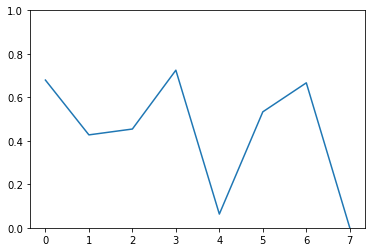

In [18]:
plt.plot(sim_list[:,0], sim_list[:,1])
plt.ylim(0,1);

In [10]:
numeric_columns = [c[0] for c in kmeans.dtypes if c[1] == 'bigint']
len(numeric_columns)

26

In [11]:
import pyspark.sql.functions as F

What columns make the difference between clusters i1=0 and i1+1?

In [12]:
ratios = []
i1 = 0
for col in numeric_columns:
    means = bkmeans.select(col, "prediction").groupby("prediction").\
        agg(mean(col), F.count(F.lit(1)).alias("count")).\
        sort(desc("count")).collect()
    ratios.append(means[i1][1]/means[i1+1][1] if means[i1+1][1] else 0)
ratios = np.array(ratios)

np.argsort(-ratios)

array([ 9, 19, 24,  1, 20, 11,  8,  7, 21,  3, 13, 22, 15, 12, 16, 14, 10,
        0, 25,  2, 18, 17,  6,  5,  4, 23])

In [18]:
-np.sort(-ratios)

array([1.1557739 , 1.01931305, 1.00462395, 0.98917342, 0.98622405,
       0.96954668, 0.91906184, 0.81908619, 0.80278718, 0.79909799,
       0.78465013, 0.78180204, 0.75572724, 0.75410202, 0.70805829,
       0.69227014, 0.64287197, 0.61575309, 0.60348654, 0.59138655,
       0.47935465, 0.37929394, 0.19059099, 0.0835376 , 0.        ,
       0.        ])